In [1]:
# !pip install pandas numpy scikit-learn matplotlib tensorflow xgboost

     ---------------------------------------- 0.0/60.9 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.9 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.9 kB ? eta -:--:--
     ------------------------------- ------ 51.2/60.9 kB 435.7 kB/s eta 0:00:01
     -------------------------------------- 60.9/60.9 kB 464.8 kB/s eta 0:00:00
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/165.9 kB ? eta -:--:--
     ------------------------- ------------ 112.6/165.9 kB 6.8 MB/s eta 0:00:01
     -------------------------------------  163.8/165.9 kB 2.5 MB/s eta 0:00:01
     -------------------------------------- 165.9/165.9 kB 2.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ---------------------------------------- 61.0/61.0 kB 1.6 MB/s eta 0:00:00
     


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: C:\Users\wgras\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



   --------------------------- ------------ 84.5/124.9 MB 1.2 MB/s eta 0:00:34
   --------------------------- ------------ 84.5/124.9 MB 1.2 MB/s eta 0:00:34
   --------------------------- ------------ 84.5/124.9 MB 1.2 MB/s eta 0:00:34
   --------------------------- ------------ 84.5/124.9 MB 1.2 MB/s eta 0:00:34
   --------------------------- ------------ 84.6/124.9 MB 1.2 MB/s eta 0:00:35
   --------------------------- ------------ 84.6/124.9 MB 1.2 MB/s eta 0:00:35
   --------------------------- ------------ 84.7/124.9 MB 1.2 MB/s eta 0:00:35
   --------------------------- ------------ 84.7/124.9 MB 1.2 MB/s eta 0:00:35
   --------------------------- ------------ 85.2/124.9 MB 1.2 MB/s eta 0:00:34
   --------------------------- ------------ 85.2/124.9 MB 1.2 MB/s eta 0:00:34
   --------------------------- ------------ 85.2/124.9 MB 1.2 MB/s eta 0:00:35
   --------------------------- ------------ 85.3/124.9 MB 1.2 MB/s eta 0:00:35
   --------------------------- ------------ 85.3/12

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree

In [2]:
# 1. Load the dataset
data = pd.read_csv('./data/BrentOilPrices.csv')

In [3]:
# 2. Preprocess the data
# Convert Date to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [4]:
data.head()

,Price
Date,
2023-04-03,84.930000
2023-04-04,84.940002
2023-04-05,84.989998
2023-04-06,85.120003
2023-04-10,84.180000


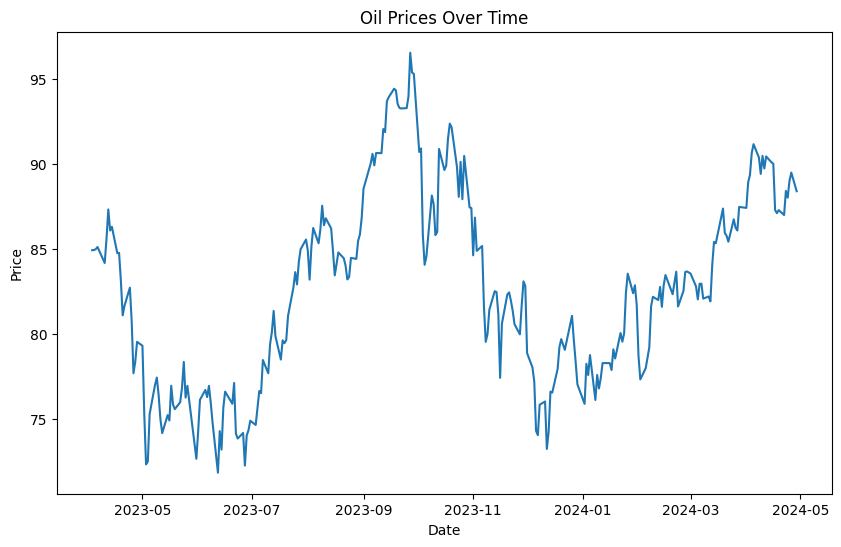

In [5]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Price'])
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [6]:
# Normalize the price data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Price'] = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

In [7]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

In [8]:
seq_length = 60
X, y = create_sequences(data['Price'].values, seq_length)

In [9]:
X[0], y[0]

(array([0.52974506, 0.53014984, 0.53217313, 0.53743435, 0.49939298,
        0.55726429, 0.62687176, 0.57668944, 0.58559277, 0.52286533,
        0.5232698 , 0.45649548, 0.37474705, 0.39741014, 0.44071243,
        0.36139206, 0.23674644, 0.26426567, 0.31161483, 0.30230673,
        0.14083377, 0.01983025, 0.02670998, 0.14002452, 0.20922721,
        0.22662908, 0.18494561, 0.12707431, 0.09429386, 0.13719167,
        0.12424146, 0.20720362, 0.1626873 , 0.15135591, 0.16794822,
        0.20234717, 0.26386089, 0.17887514, 0.20679884, 0.06879822,
        0.03318523, 0.09874552, 0.17361391, 0.19708626, 0.18008917,
        0.20679884, 0.16673418, 0.11938502, 0.        , 0.0991503 ,
        0.05503846, 0.15499801, 0.19303938, 0.16430611, 0.21367887,
        0.09307982, 0.08134365, 0.09469864, 0.0169974 , 0.08862816]),
 0.10117358643196983)

In [10]:
X.shape, y.shape

((211, 60), (211,))

In [11]:
# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = y[:split], y[split:]

In [12]:
X_train.shape, Y_train.shape

((168, 60), (168,))

In [35]:
# Reshape X for LSTM [samples, time steps, features]
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [17]:
# call back to avoid overfitting
early_stop = xgb.callback.EarlyStopping(rounds=10,
                                        metric_name='rmse',
                                        maximize=False,
                                       save_best= True,
                                        )

AttributeError: type object 'XGBRegressor' has no attribute 'callback'

In [14]:
# 3. Build the XGBoost model
model1 = XGBRegressor(random_state=seed0,verbosity=0, n_jobs = -1, reg_lambda=0.005, 
                         learning_rate=0.01, device='gpu',
                          n_estimators=5000, objective='reg:squarederror',
                        callbacks=[early_stop])
model1

NameError: name 'seed0' is not defined

In [16]:
# 4. Train the model

model1.fit(
    X_train, 
    Y_train, 
    # eval_set=(X_test, Y_test), 
    verbose=True
)

NameError: name 'model1' is not defined

In [23]:
# 5. Evaluate the model
train_predict = model1.predict(X_train)
test_predict = model1.predict(X_test)

In [25]:
train_predict.shape

(168,)

In [31]:
# invert predictions
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))
# train_predict.shape
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

# y_pred = model1.predict(X_test)
# y_pred = scaler.inverse_transform(y_pred)
# y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [32]:
print('Model 01:')

print('Train Mean Absolute Error:', mean_absolute_error(Y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Model 01:
Train Mean Absolute Error: 1300874.001676672
Train Root Mean Squared Error: 1303345.4252408831
Test Mean Absolute Error: 2128.3808571340824
Test Root Mean Squared Error: 2129.370929014909


In [44]:
model1.save_model('models/XGBoost_01.json') 

# returns a compiled model
# identical to the previous one
# model1 = load_model('my_model.h5')

#### model 2